Reference:
* [Notebook](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/ungradedLab/Wlfvj/implement-a-fully-convolutional-neural-network) in course "Advanced Computer Vision with TensorFlow" by DeepLearning.AI

* [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) TF official tutorial.

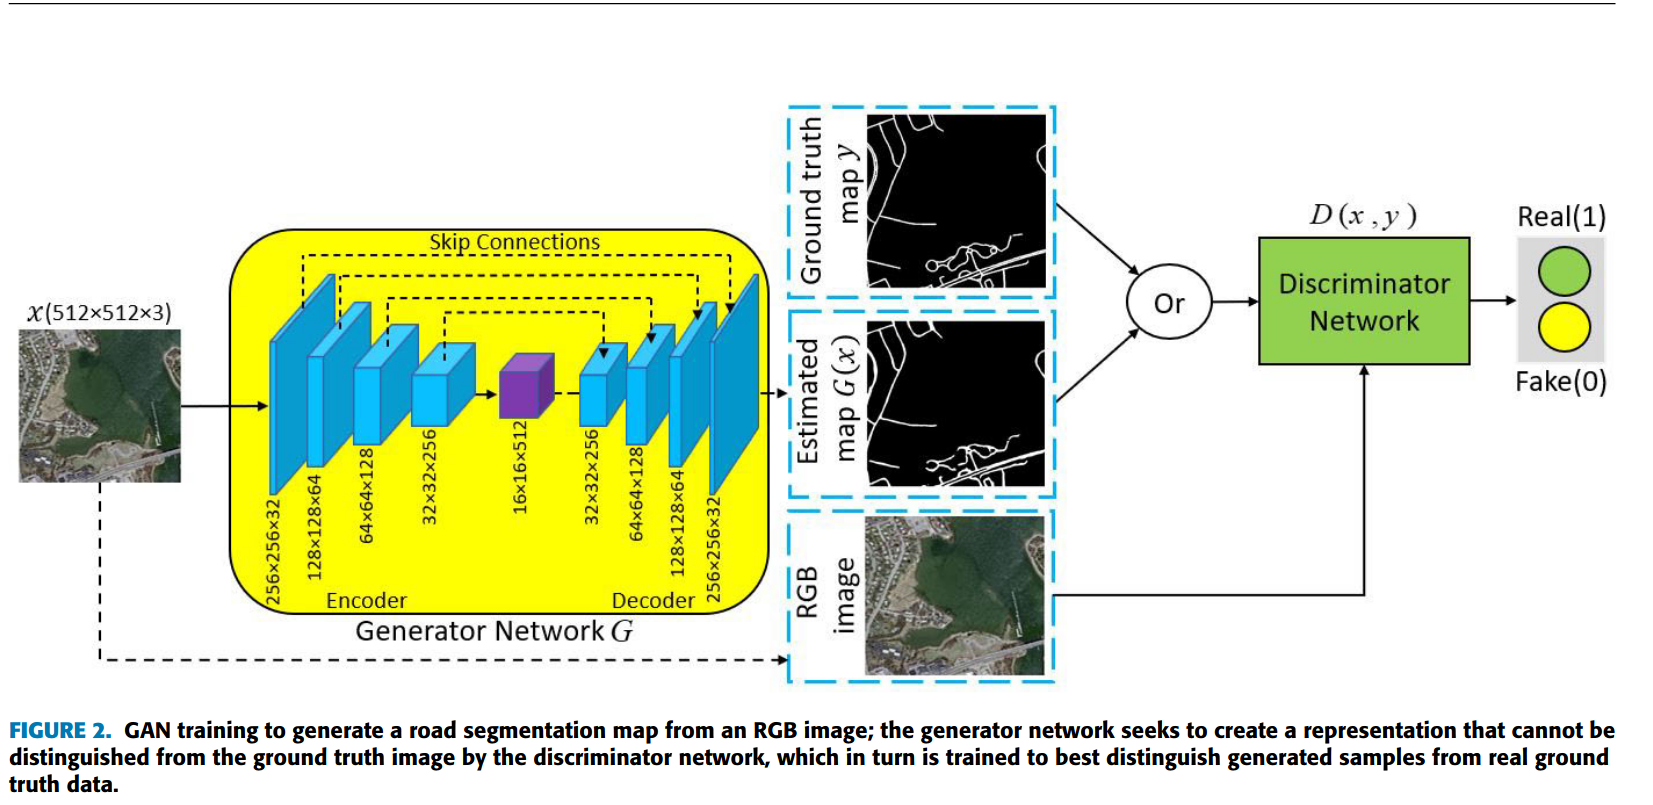

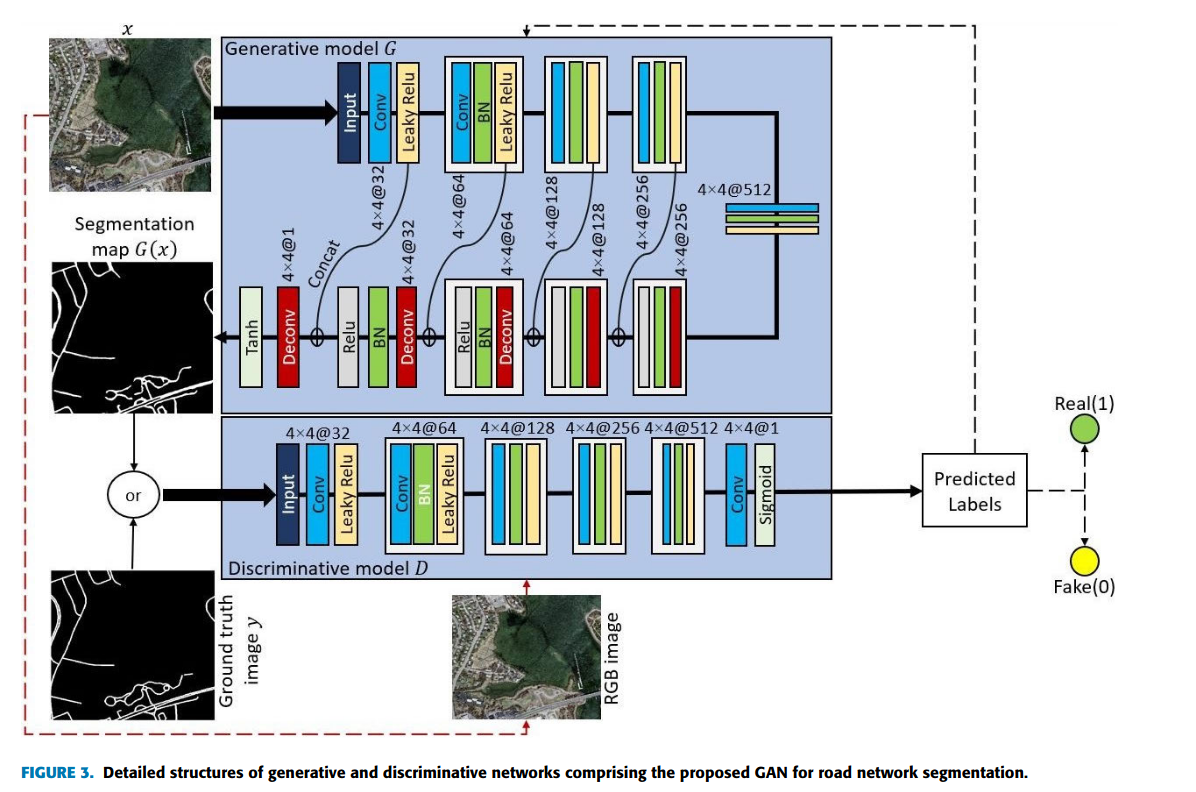

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

from glob import glob
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

# Generator

In [3]:
BATCH_SIZE = 2

IMG_SIZE = 512

MASK_SIZE = 512

NUM_CLASSES = 5

NUM_TRAIN_IMAGES = 7470

NUM_VAL_IMAGES = 1602

NUM_TEST_IMAGES = 1602

VERSION = '3.2'

## Encoder Utilities

In [4]:
def encoder_block(input_tensor, n_filters, block_name,
                 kernel_size=4, batch_normalization=True):
    """
    Creates encoder block which consists of:
    
    Conv2d → BatchNormalization(except first block) → LeakyReLu
    
    Args:
        input_tensor (tensor) -- the input te nsor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution
        batch_normalization -- if BatchNormalization layer should be
                               included
    Returns:
        x -- the output features of the convolution block 

    
    """
    
    x = input_tensor
    
    x = layers.Conv2D(filters=n_filters, 
                      kernel_size=kernel_size,
                      strides=(2,2),
                      activation='relu', 
                      padding='same',
                      name=block_name + '_Conv2D')(x)

    if batch_normalization:

        x = layers.BatchNormalization(name=block_name + '_BN')(x)

    x = layers.LeakyReLU(name=block_name + '_LeakyRelu')(x)
    
    return x

## Encoder

In [5]:
def encoder(inputs):
    '''
    This function defines the encoder or downsampling path.

    Args:
    inputs (tensor) -- batch of input images

    Returns:
        (e1, e2, e3, e4) -- tuple of features for concating layers
            in decoder
        e5 -- final output to pass to decoder

    '''
    e1 = encoder_block(inputs, n_filters=32,
                       block_name='encoder_block_1', 
                       batch_normalization=False)
    
    e2 = encoder_block(e1, n_filters=64, block_name='encoder_block_2')
    
    e3 = encoder_block(e2, n_filters=128, block_name='encoder_block_3')
    
    e4 = encoder_block(e3, n_filters=256, block_name='encoder_block_4')
    
    e5 = encoder_block(e4, n_filters=512, block_name='encoder_block_5')
    
    return (e1, e2, e3, e4, e5)


## Decoder Utilities

In [6]:
def decoder_block(input_tensor, n_filters, block_name,
                 kernel_size=4):
    """
    Creates encoder block which consists of:
    
    Conv2d → BatchNormalization(except first block) → LeakyReLu
    
    Args:
        input_tensor (tensor) -- the input te nsor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution
        batch_normalization -- if BatchNormalization layer should be
                               included
    Returns:
        x -- the output features of the convolution block 

    
    """
    
    x = input_tensor
    
    x = layers.Conv2DTranspose(filters=n_filters, 
                              kernel_size=kernel_size,
                              strides=(2,2),
                              activation='relu', 
                              padding='same',
                              name=block_name + '_Conv2DTranspose')(x)
        
    x = layers.BatchNormalization(name=block_name + '_BN')(x)

    x = layers.ReLU(name=block_name + '_ReLu')(x)
     
    return x

## Decoder

In [7]:
def decoder(convs):
    '''
    This function defines the decoder.

    Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks

    Returns:
    
    outputs: mask with each pixel having assigned s
    '''
    
    e1, e2, e3, e4, e5 = convs
    
    
    d1 = decoder_block(e5, n_filters=256,
                       block_name='decoder_block_1')
    
    c1 = layers.concatenate([d1, e4])
    
    d2 = decoder_block(c1, n_filters=128, block_name='decoder_block_2')
    
    c2 = layers.concatenate([d2, e3])
    
    d3 = decoder_block(c2, n_filters=64, block_name='decoder_block_3')
    
    c3 = layers.concatenate([d3, e2])
    
    d4 = decoder_block(c3, n_filters=32, block_name='decoder_block_4')
    
    c4 = layers.concatenate([d4, e1])
    
    outputs = layers.Conv2DTranspose(filters=NUM_CLASSES,
                                kernel_size=4,
                                strides=(2,2), 
                                padding='same',
                                name='decoder_output')(c4)
    
#     outputs = layers.Activation(activation=tf.nn.sigmoid,
#                                 name='decoder_output')(d5)
    
    
    return outputs

## Define and instantiate the model

In [8]:
def make_generator():
    '''
    Defines MUNet by connecting encoder and decoder.
    
    '''
    
    # specify input shape; image is in RGB
    inputs = layers.Input(shape=[512,512,3])
    
    # feed the inputs to the encoder
    encoder_output = encoder(inputs)
    
    # feed the encoder output and encoder block outputs to the decoder
    # specify the number of classes via the 'output_channels' argument
    outputs = decoder(encoder_output)
    
    # create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs,
                          name='Generator')
    
    return model


# instantiate the model
generator= make_generator()

# see the resulting model architecture
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
encoder_block_1_Conv2D (Conv2D) (None, 256, 256, 32) 1568        input_1[0][0]                    
__________________________________________________________________________________________________
encoder_block_1_LeakyRelu (Leak (None, 256, 256, 32) 0           encoder_block_1_Conv2D[0][0]     
__________________________________________________________________________________________________
encoder_block_2_Conv2D (Conv2D) (None, 128, 128, 64) 32832       encoder_block_1_LeakyRelu[0][0]  
__________________________________________________________________________________________

In [9]:
# tf.keras.utils.plot_model(generator, show_shapes=True, to_file='GAN_MUNET.png')

# Discriminator

## Utilities

In [10]:
def discriminator_block(input_tensor, n_filters, block_name,
                 kernel_size=4, batch_normalization=True):
    """
    Creates encoder block which consists of:
    
    Conv2d → BatchNormalization(except first block) → LeakyReLu
    
    Args:
        input_tensor (tensor) -- the input tensor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution
        batch_normalization -- if BatchNormalization layer should be
                               included
    Returns:
        x -- the output features of the discriminator block 
    """
    
    x = input_tensor
    
    x = layers.Conv2D(filters=n_filters, 
                      kernel_size=kernel_size,
                      strides=(2, 2),
                      activation='relu', 
                      padding='same',
                      name=block_name + '_Conv2D')(x)

    if batch_normalization:

        x = layers.BatchNormalization(name=block_name + '_BN')(x)

    x = layers.LeakyReLU(name=block_name + '_LeakyRelu')(x)
    
    return x

## Model

discriminator_block(input_tensor, n_filters, block_name,
                 kernel_size=4, batch_normalization=True)

In [11]:
def make_discriminator(input_shape = [512, 512, 5]):
    
    '''
    This function defines the discriminator.

    Args:
    inputs (tensor) -- batch of input images

    Returns:
    
    '''
    inputs = layers.Input(shape=input_shape)
    
    d1 = discriminator_block(inputs, 32, 'discriminator_block_1',
                            batch_normalization=False)
    
    d2 = discriminator_block(d1, 64, 'discriminator_block_2')
    
    d3 = discriminator_block(d2, 128, 'discriminator_block_3')
    
    d4 = discriminator_block(d3, 256, 'discriminator_block_4')
    
    d5 = discriminator_block(d4, 512, 'discriminator_block_5')
    
    outputs = layers.Conv2D(filters=1, 
                      kernel_size=4,
                      strides=(2, 2),
                      padding='same',
                      name='discriminator_block_5_Conv2d')(d5)
    
#     outputs = layers.Activation(activation='sigmoid',
#                               name='discriminator_output')(d6)
    
#     d8 = layers.Flatten()(d6)
    
#     outputs = layers.Dense(1, activation='sigmoid')(d8)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs,
                           name='Discriminator')
    
    return model

In [12]:

discriminator = make_discriminator()

discriminator.summary()
    

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 5)]     0         
_________________________________________________________________
discriminator_block_1_Conv2D (None, 256, 256, 32)      2592      
_________________________________________________________________
discriminator_block_1_LeakyR (None, 256, 256, 32)      0         
_________________________________________________________________
discriminator_block_2_Conv2D (None, 128, 128, 64)      32832     
_________________________________________________________________
discriminator_block_2_BN (Ba (None, 128, 128, 64)      256       
_________________________________________________________________
discriminator_block_2_LeakyR (None, 128, 128, 64)      0         
_________________________________________________________________
discriminator_block_3_Conv2D (None, 64, 64, 128)     

# Load data

In [13]:
abs_path = %pwd

In [14]:
slash_idx = [idx for idx,ch in enumerate(abs_path) if ch=='/']

abs_path = abs_path[:slash_idx[-2]]

In [15]:
DATA_DIR = abs_path + '/data/processed'

In [16]:
TRAIN_PATH = DATA_DIR + '/train'
VAL_PATH = DATA_DIR + '/val'
TEST_PATH = DATA_DIR + '/test'

In [17]:
# def get_data_generator(path_to_data_split):
    
#     seed = 909
    
#     image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
#     mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    
#     image_generator = image_datagen.flow_from_directory(path_to_data_split+'/images',
#                                                        class_mode=None,
#                                                        batch_size=BATCH_SIZE,
#                                                        seed=seed,
#                                                        target_size=IMG_SIZE)

#     mask_generator = mask_datagen.flow_from_directory(path_to_data_split+'/masks',
#                                                      class_mode=None,
#                                                      batch_size=BATCH_SIZE,
#                                                      seed=seed,
#                                                      target_size=IMG_SIZE)
        
#     generator = zip(image_generator, mask_generator)

    
#     return generator 

In [18]:
train_images = sorted(glob(os.path.join(TRAIN_PATH, "images/img/*")))
train_masks = sorted(glob(os.path.join(TRAIN_PATH, "masks/img/*")))
val_images = sorted(glob(os.path.join(VAL_PATH, "images/img/*")))
val_masks = sorted(glob(os.path.join(VAL_PATH, "masks/img/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image = image[..., 0]
        image = tf.reshape(image, (MASK_SIZE, MASK_SIZE, 1))
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[MASK_SIZE, MASK_SIZE])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
        image = image / 255.
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def load_augmented_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    image, mask = augmentation(image, mask)
    return image, mask


def data_generator(image_list, mask_list, augmentation=False, factor=1):
    
    """
    Returns augmented or not augmented dataset with the same amount of elements.
    
    Args:
    image_list: list of paths to each image
    mask_list: list of paths to corresponding masks of images (sorted)
    augmentation: "True" for getting augmeneted images and masks
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    
    if augmentation:
        dataset = dataset.map(load_augmented_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    else:
        dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    
    if factor > 1 and augmentation:
        for _ in range(factor-1):
            dataset_to_concat = dataset.map(load_augmented_data, num_parallel_calls=tf.data.AUTOTUNE)
            dataset = dataset.concatenate(dataset_to_concat)

    return dataset

In [19]:
train_dataset = data_generator(train_images, train_masks, augmentation=False)
val_dataset = data_generator(val_images, val_masks)


print("Train Dataset:", train_dataset)
print("Number of images in Train Dataset:", BATCH_SIZE * len(train_dataset))
print("Val Dataset:", val_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(val_dataset))


Train Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Train Dataset: 7470
Val Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1602


In [20]:
test_images = sorted(glob(os.path.join(TEST_PATH, "images/img/*")))
test_masks = sorted(glob(os.path.join(TEST_PATH, "masks/img/*")))
test_dataset = data_generator(test_images, test_masks)

print("Test Dataset:", test_dataset)

Test Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>


## Images utilities

In [21]:
def mask_to_categorical(mask):
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), NUM_CLASSES)
    mask = tf.cast(mask, tf.float32)
    return mask

In [22]:
import matplotlib.pyplot as plt
import matplotlib

In [23]:
def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

In [24]:
def show_predictions():

    img, mask = zip(next(iter(test_dataset)))

    sample_img = img[0][0]
    sample_mask = mask[0][0]
    
    fig = plt.figure()

    f,ax = plt.subplots(1, 3, figsize=(12,6))
    
    ax[0].imshow(sample_img)
    ax[0].set_title('Real image')
    ax[0].axis('off')

    ax[1].imshow(sample_mask[:, :, 0])
    ax[1].set_title("Real mask")
    ax[1].axis('off')

    ax[2].imshow(create_mask(generator.predict(sample_img[tf.newaxis, ...])))
    ax[2].set_title("Generated mask")
    ax[2].axis('off')

In [25]:
show_predictions()

<Figure size 432x288 with 0 Axes>

# Loss and optimizers

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                              beta_1=0.9,
                                              beta_2=0.999)

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                                  beta_1=0.9,
                                                  beta_2=0.999)

In [27]:
# y_true = [[0, 1.0, 0, 0, 0]]
# y_pred = [[0, 1,0.0, 0.0, 0.0]]
# # Using 'auto'/'sum_over_batch_size' reduction type.
# scce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# scce(y_true, y_pred).numpy()

In [28]:
# y_true = [[1.0]]
# y_pred = [[0.0]]
# # Using 'auto'/'sum_over_batch_size' reduction type.
# scce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# scce(y_true, y_pred).numpy()

In [29]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss


# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
def _to_float(tensor):
    return tf.cast(tensor, tf.float32)


def wasserstein_generator_loss(
    discriminator_gen_outputs,
    weights=1.0,
    scope=None,
    loss_collection=tf.compat.v1.GraphKeys.LOSSES,
    reduction=tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
    add_summaries=False):
    """Wasserstein generator loss for GANs.
    See `Wasserstein GAN` (https://arxiv.org/abs/1701.07875) for more details.
    Args:
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
    weights: Optional `Tensor` whose rank is either 0, or the same rank as
      `discriminator_gen_outputs`, and must be broadcastable to
      `discriminator_gen_outputs` (i.e., all dimensions must be either `1`, or
      the same as the corresponding dimension).
    scope: The scope for the operations performed in computing the loss.
    loss_collection: collection to which this loss will be added.
    reduction: A `tf.losses.Reduction` to apply to loss.
    add_summaries: Whether or not to add detailed summaries for the loss.
    Returns:
    A loss Tensor. The shape depends on `reduction`.
    """
    with tf.compat.v1.name_scope(scope, 'generator_wasserstein_loss',
                               (discriminator_gen_outputs, weights)) as scope:
        
        discriminator_gen_outputs = _to_float(discriminator_gen_outputs)

        loss = - discriminator_gen_outputs
        loss = tf.compat.v1.losses.compute_weighted_loss(loss, weights, scope,
                                                         loss_collection, reduction)

        if add_summaries:
            tf.compat.v1.summary.scalar('generator_wass_loss', loss)

    return loss


def wasserstein_discriminator_loss(
    discriminator_real_outputs,
    discriminator_gen_outputs,
    real_weights=1.0,
    generated_weights=1.0,
    scope=None,
    loss_collection=tf.compat.v1.GraphKeys.LOSSES,
    reduction=tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
    add_summaries=False):
    
    """Wasserstein discriminator loss for GANs.
    See `Wasserstein GAN` (https://arxiv.org/abs/1701.07875) for more details.
    
    Args:
    
    discriminator_real_outputs: Discriminator output on real data.
    
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
    
    real_weights: Optional `Tensor` whose rank is either 0, or the same rank as
      `discriminator_real_outputs`, and must be broadcastable to
      `discriminator_real_outputs` (i.e., all dimensions must be either `1`, or
      the same as the corresponding dimension).
    
    generated_weights: Same as `real_weights`, but for
      `discriminator_gen_outputs`.
    
    scope: The scope for the operations performed in computing the loss.
    
    loss_collection: collection to which this loss will be added.
    
    reduction: A `tf.losses.Reduction` to apply to loss.
    
    add_summaries: Whether or not to add summaries for the loss.
    
    Returns:
    A loss Tensor. The shape depends on `reduction`.
    """
    
    with tf.compat.v1.name_scope(
        scope, 'discriminator_wasserstein_loss',
        (discriminator_real_outputs, discriminator_gen_outputs, real_weights,
        generated_weights)) as scope:

        discriminator_real_outputs = _to_float(discriminator_real_outputs)
        discriminator_gen_outputs = _to_float(discriminator_gen_outputs)
        discriminator_real_outputs.shape.assert_is_compatible_with(
            discriminator_gen_outputs.shape)

        loss_on_generated = tf.compat.v1.losses.compute_weighted_loss(
            discriminator_gen_outputs,
            generated_weights,
            scope,
            loss_collection=None,
            reduction=reduction)
        loss_on_real = tf.compat.v1.losses.compute_weighted_loss(
            discriminator_real_outputs,
            real_weights,
            scope,
            loss_collection=None,
            reduction=reduction)
        loss = loss_on_generated - loss_on_real
        tf.compat.v1.losses.add_loss(loss, loss_collection)

        if add_summaries:
            tf.compat.v1.summary.scalar('discriminator_gen_wass_loss',
                                      loss_on_generated)
            tf.compat.v1.summary.scalar('discriminator_real_wass_loss', loss_on_real)
            tf.compat.v1.summary.scalar('discriminator_wass_loss', loss)

    return loss


generator_loss = wasserstein_generator_loss

discriminator_loss = wasserstein_discriminator_loss

## Utilities for displaying images

In [31]:
def infer(model, image_tensor):
    predictions = model(np.expand_dims((image_tensor), axis=0), training=False)
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    image = tf.image.resize(image, [512, 512])
    image.set_shape([None, None, 3])
    image = tf.reshape(image, (512,512,3))
    overlay = tfa.image.blend(image, colored_mask, 0.5)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3), save_path=None):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    
    if save_path != None:
        plt.savefig(save_path)
    
    plt.show()


def plot_predictions(images_list, masks_list, colormap, model, save_path):
    for image_file, mask_file in zip(images_list, masks_list):
        image_tensor = read_image(image_file)
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]
        mask_tensor = decode_segmentation_masks(mask_tensor, colormap, NUM_CLASSES)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        overlay_orginal = get_overlay(image_tensor, mask_tensor)
        plot_samples_matplotlib(
            [image_tensor, overlay_orginal, overlay, prediction_colormap], figsize=(18, 14), save_path=save_path
        )


In [32]:
COLORMAP = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]]

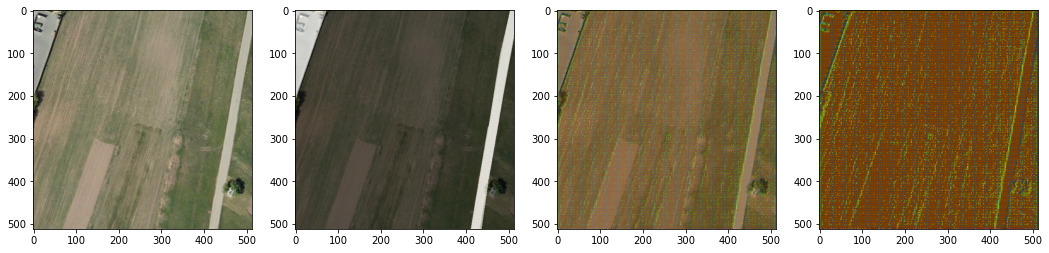

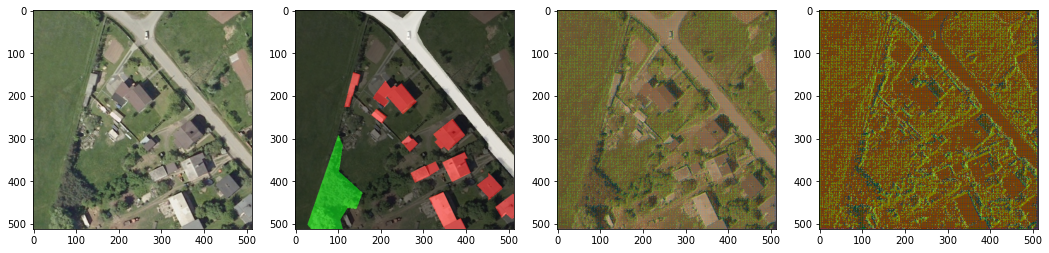

In [33]:
left_range = 448
right_range = 450

plot_predictions(test_images[left_range:right_range], test_masks[left_range:right_range] , COLORMAP, model=generator, save_path=None)

## Metrics

In [34]:
def get_miou_for_images(images_list, masks_list, model):
    
    m = tf.keras.metrics.MeanIoU(NUM_CLASSES)
    
    for image_file, mask_file in zip(images_list, masks_list):
        
        image_tensor = read_image(image_file)
        
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]

        prediction_mask = infer(image_tensor=image_tensor, model=model)
        
        m.update_state([mask_tensor], [prediction_mask])
        
    return m.result().numpy()

# Train GAN

In [35]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [36]:
EPOCHS = 50

In [37]:
checkpoint_dir = f'./results/GAN_MUnet/{VERSION}_version/each_epoch_ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [38]:
def mask_to_categorical(mask):
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), NUM_CLASSES)
    mask = tf.cast(mask, tf.float32)
    return mask

In [39]:
images_batch, masks_batch = next(iter(train_dataset))

mask_to_categorical(masks_batch).shape

TensorShape([2, 512, 512, 5])

In [40]:
@tf.function
def train_step(tuple_images_masks_batch):
    
    images_batch, masks_batch = tuple_images_masks_batch
    
    masks_batch = mask_to_categorical(masks_batch)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_masks = generator(images_batch, training=True)

        real_output = discriminator(masks_batch, training=True)
        fake_output = discriminator(generated_masks, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [41]:
def train(dataset, epochs):
    
    i_when_end = 7470 // BATCH_SIZE
    
    miou_data = []
    
    for epoch in range(epochs):
        start = time.time()
        
        i = 0
        
        for image_batch in dataset:
            
            if i > i_when_end:
                break
            
            train_step(image_batch)
            
            i += 1

        display.clear_output(wait=True)
        
        save_fig_path = './results/GAN_MUnet/{}_version/images_predictions/image_at_epoch_{:04d}_pred_iter_{}.png'.format(VERSION, epoch, str(i))
        
        left_range = np.random.randint(0, NUM_TEST_IMAGES-10)
        right_range = left_range + 4
        
        plot_predictions(val_images[left_range:right_range],
                         val_masks[left_range:right_range],
                         colormap=COLORMAP,
                         save_path=save_fig_path,
                         model=generator)
        
        miou = get_miou_for_images(val_images, val_masks, generator)
        
        print(f'val_mIoU = {miou}')

        # Save the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [42]:
pred_images_path = f'./results/GAN_MUnet/{VERSION}_version/images_predictions'

if not os.path.exists(pred_images_path):
    os.makedirs(pred_images_path)
    
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [43]:
# datasets for testing purposes
train_dataset = data_generator(train_images, train_masks, augmentation=False)
val_dataset = data_generator(val_images, val_masks)

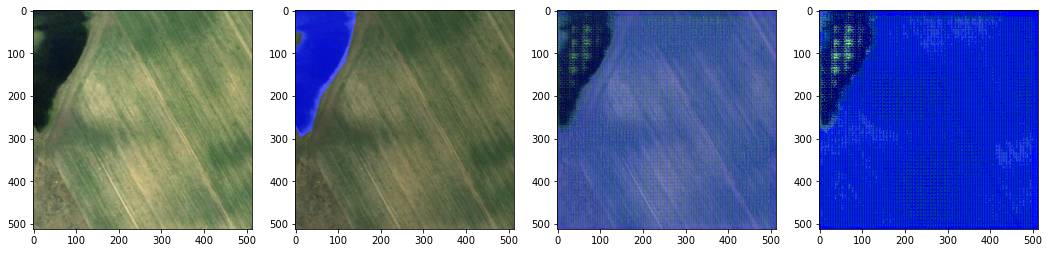

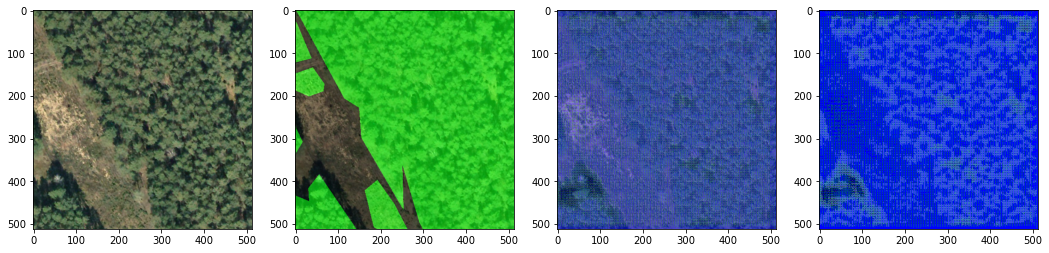

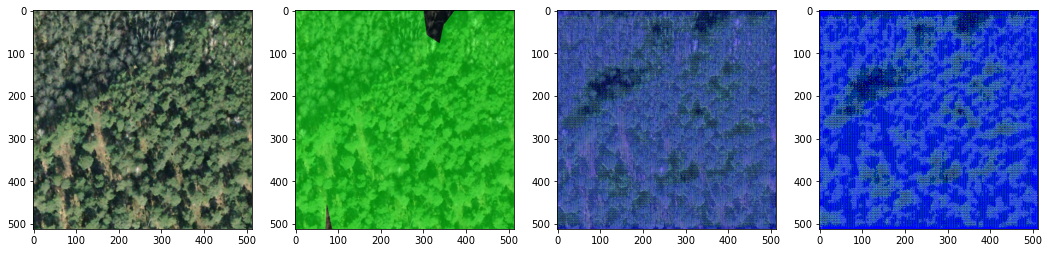

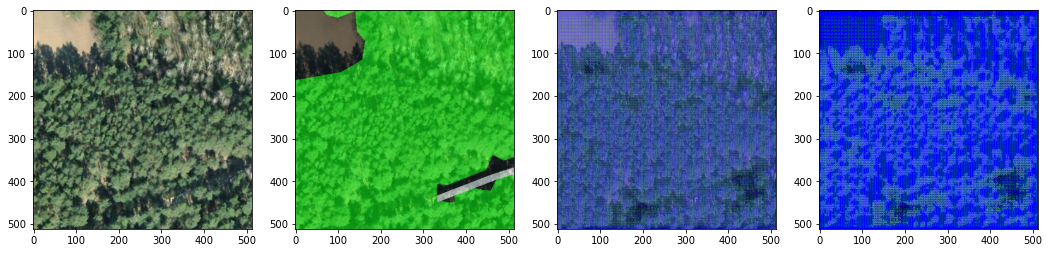

val_mIoU = 0.0534994974732399
Time for epoch 12 is 294.678103685379 sec


KeyboardInterrupt: 

In [44]:
train(train_dataset, EPOCHS)

In [ ]:
discriminator.save_weights(f'./results/GAN_MUnet/{VERSION}_version/last_epoch/discriminator.h5')

In [ ]:
generator.save_weights(f'./results/GAN_MUnet/{VERSION}_version/last_epoch/generator.h5')

In [ ]:
show_predictions()

In [ ]:
val_img, val_mask = zip(next(test_generator))

val_img = val_img[0]

val_mask = val_mask[0]

predictions = generator(val_img, training=False)

fig = plt.figure()

f,ax = plt.subplots(1, 3, figsize=(12,6))

ax[0].imshow(create_mask(predictions))
ax[0].set_title('Generated mask')
ax[0].axis('off')

ax[1].imshow(val_mask[0,:,:,0])
ax[1].set_title("Real mask")
ax[1].axis('off')

ax[2].imshow(val_img[0])
ax[2].set_title("Image")
ax[2].axis('off')


In [ ]:
predictions[0, :5, 35, :]

In [ ]:
discriminator(predictions, training=False)

In [ ]:
discriminator(mask_to_categorical(val_mask), training=False)